In [11]:
import os
import sys
# sys.path.append(os.path.abspath(os.path.dirname(__file__)))  # ensures current directory is included
sys.path.append("/home/s27mhusa_hpc/Master-Thesis/XMI_Files")
import spacy
from collections import Counter
import json


In [24]:
input_label_dir = "/home/s27mhusa_hpc/Master-Thesis/DatasetsFinalPredictions/Test_BIO_labels_German"
input_token_dir = "/home/s27mhusa_hpc/Master-Thesis/DatasetsFinalPredictions/Test_BIO_tokens_German"


all_labels = []


import os

# List of labels to remap to "locationName"
to_location = ["city", "country", "region", "latitude", "longitude"]

# Your usual label removal list
remove_labels = [ "Crops", "Soil"
]

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        content = file.read()
    tokens = eval(content)

    i = 0
    while i < len(labels):
        label = labels[i]

        # 1. Remap city, country, region, latitude, longitude to locationName (BIO-consistent)
        for loc_label in to_location:
            if label == f"B-{loc_label}":
                # Change B-XXX to B-locationName and all subsequent I-XXX to I-locationName
                labels[i] = "B-locationName"
                j = i + 1
                while j < len(labels) and labels[j] == f"I-{loc_label}":
                    labels[j] = "I-locationName"
                    j += 1
                i = j
                break
            elif label == f"I-{loc_label}":
                labels[i] = "I-locationName"
        else:
            # 2. Handle labels to remove (convert to O)
            if any(label == f"B-{remove_label}" for remove_label in remove_labels):
                remove_type = label[2:]  # Remove "B-" prefix
                entity_tokens = [i]
                j = i + 1
                while j < len(labels) and labels[j] == f"I-{remove_type}":
                    entity_tokens.append(j)
                    j += 1

                for k in entity_tokens:
                    labels[k] = "O"
                i = j
            else:
                i += 1

    with open(label_path, "w", encoding="utf-8") as file:
        file.write(str(labels))


In [25]:
from collections import Counter


all_labels = []
b_location_examples = []  # Store (label, token) pairs for B-locationName

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)
    
    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        token_content = file.read()
    tokens = eval(token_content)

    # Extend for overall count
    all_labels.extend(labels)

    # Collect B-locationName examples
    for label, token in zip(labels, tokens):
        if label == "I-cropSpecies":
            b_location_examples.append((label, token))
            print(filename)

# Count only B- labels and strip B-
b_counts = Counter(label[2:] for label in all_labels if label.startswith("B-"))

# Print label counts
print("📊 B-Label Counts:")
for label, count in b_counts.items():
    print(f"{label}: {count}")

# Print all B-locationName examples
print("\n📍 Tokens with B-Soil:")
for label, token in b_location_examples:
    print(f"{label}: {token}")


📊 B-Label Counts:
cropSpecies: 6
endTime: 4
startTime: 4
soilOrganicCarbon: 3
locationName: 2
duration: 2
soilTexture: 3
soilReferenceGroup: 1
soilDepth: 4

📍 Tokens with B-Soil:


In [26]:
location_names = []
filenames = []

for filename in os.listdir(input_label_dir):
    label_path = os.path.join(input_label_dir, filename)
    with open(label_path, "r", encoding="utf-8") as file:
        content = file.read()
    labels = eval(content)

    token_path = os.path.join(input_token_dir, f"tokens_{filename}")
    with open(token_path, "r", encoding="utf-8") as file:
        tokens = eval(file.read())

    i = 0
    while i < len(labels):
        if labels[i] == "B-Crops":
            location_tokens = [tokens[i]]
            i += 1
            while i < len(labels) and labels[i] == "I-Crops":
                location_tokens.append(tokens[i])
                i += 1
            location_names.append(" ".join(location_tokens))
            filenames.append(filename)
        else:
            i += 1

# Print full location names
print("\n📍 Full Location Names:")
for loc in location_names:
    print(loc)
print("\n📍 Full filenames Names:")
for filename in filenames:
    print(filename)


📍 Full Location Names:

📍 Full filenames Names:


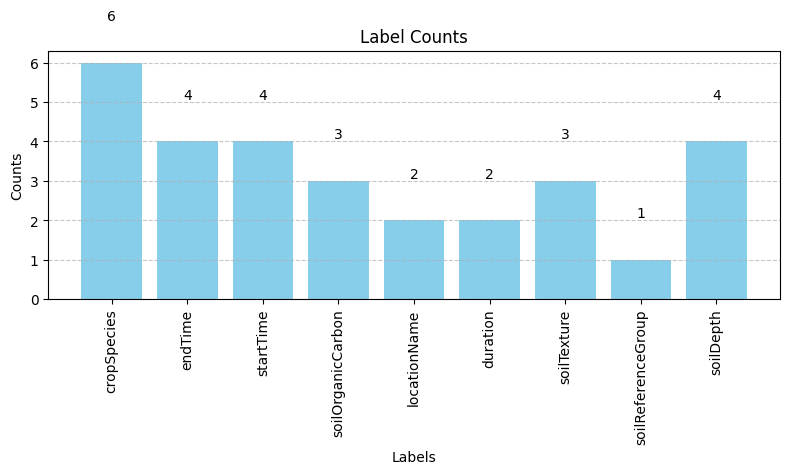

In [27]:
import matplotlib.pyplot as plt
# Extract labels and counts
labels = list(b_counts.keys())
counts = list(b_counts.values())

# Create bar chart
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color='skyblue')
plt.title("Label Counts")
plt.xlabel("Labels")
plt.ylabel("Counts")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=90)

# Add count labels above bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.tight_layout()
plt.show()